# Encoders: Variational Auto-Encoder Example
Variational auto-encoders are encoders are a type of __Generative Model__. Generative models are typically used to create new data. Like for instance a picture of non-existing person. 

Other than regular auto-encoders, the latent features are not continous values, but rather distributions. The latent features consist of a *mean* and a *standard deviation* describing a distribution over the latent space. 

The loss of a variational auto-encoder consists of 2 parts.
1. A reconstruction loss. It captures how different the reconstructed output is to the input.
2. The KL-Divergence of the latent distributions to the actual 'prior' distribution, which is assumed to be Normally distributed. KL-Divergence is a measure of difference between distributions. Adding it to the loss forces the latent distributions to be more or less Normal. Without it the model could use very *narrow* distributions which would make it more like a regular auto-encoder.

We won't go into the details here but this give the latent space better properties for sampling.

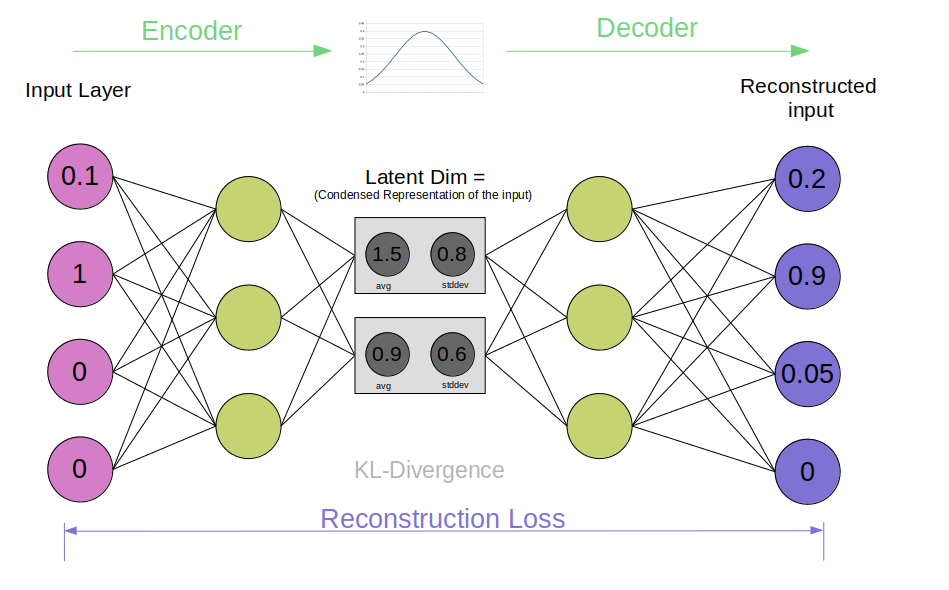

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base and derived features and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object. The DataFrame can be used for basic data analysis

In [3]:
# Change this to read from another location
file = '../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        age,
        gender,
        merchant,
        category,
        amount_binned,
        fraud
    ])

amount_oh = ft.FeatureOneHot('amount_one_hot', amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    df = e.from_df(learning_features, df, inference=False)
    data_list = e.to_numpy_list(learning_features, df)

print(data_list.shapes)
print(data_list.dtype_names)

2020-11-11 11:25:17.370 d373c7.engines.common          INFO     Start Engine...
2020-11-11 11:25:17.371 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-11 11:25:17.371 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-11 11:25:17.372 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../data/bs140513_032310.csv
2020-11-11 11:25:17.571 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-11-11 11:25:17.577 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 6)
2020-11-11 11:25:17.578 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-11-11 11:25:17.593 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 6)
2020-11-11 11:25:17.594 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <Fa

[(594643, 107), (594643,)]
['int8', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a training-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__. For auto-encoders we perform a 4th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 4. Remove fraud from training and validation

In [5]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(learning_features, 0)
val_data = val_data.filter_label(learning_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(458847, 107), (458847,)]
Validation Data shapes [(29670, 107), (29670,)]
Test Data shapes [(100000, 107), (100000,)]
Done


## Set-up devices

In [6]:
device, cpu = pt.init_devices()

2020-11-11 11:25:23.044 d373c7.pytorch.common          INFO     Torch Version : 1.6.0
2020-11-11 11:25:23.111 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-11-11 11:25:23.111 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


In [11]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, shuffle=True)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a model
d = pm.AutoEncoderDefaults()
d.set_vae_kl_weight(0.5)
m = pm.LinearToBinaryVariationalAutoEncoder(learning_features, 3, [16], d)
print(m)

LinearToBinaryVariationalAutoEncoder(
  Number of parameters : 3713
  (encoder): _LatentVAEEncoder(
    Number of parameters : 1830
    (head): TensorDefinitionHead(lcs=['Binary'])
    (linear): LinDropAct(
      (layers): Sequential(
        (0): Linear(in_features=107, out_features=16, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU(inplace=True)
      )
    )
    (latent): VAELinearToLatent(
      output_size=3
      (mu): Linear(in_features=16, out_features=3, bias=True)
      (s): Linear(in_features=16, out_features=3, bias=True)
    )
  )
  (decoder): _LatentVAEDecoder(
    (linear): LinDropAct(
      (layers): Sequential(
        (0): Linear(in_features=3, out_features=16, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU(inplace=True)
      )
    )
    (to_linear): VAELatentToLinear(re-parameterization layer)
  )
  (out): BinaryOutput(
    (out_block): Sequential(
      (0): Linear(in_features=16, out_features=107, bias=True)
      

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr funtion and plot. 

2020-11-11 11:26:49.978 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 372.13it/s]
2020-11-11 11:26:50.518 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


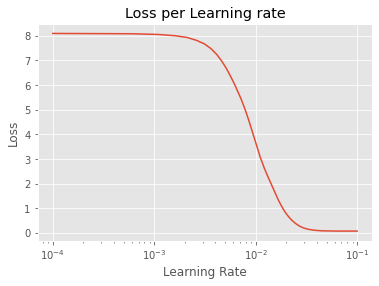

In [12]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __5 epochs__ and __learning rate 8e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate.

Epoch 005/005: 100%|██████████| 3817/3817 [00:08<00:00, 435.44it/s, train_loss=0.0676, val_loss=0.0669]


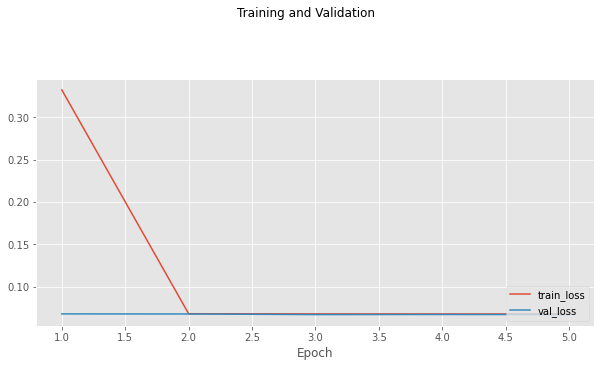

In [13]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 8e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the Model

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 932.14it/s]


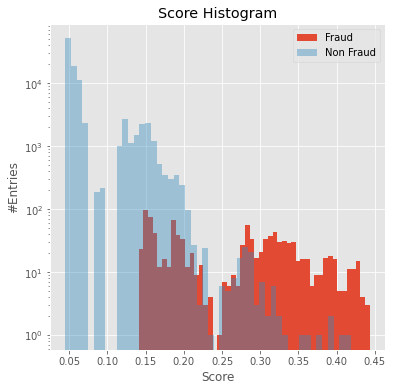

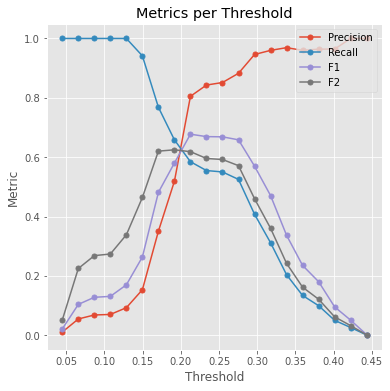

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.69      0.62      0.65      1074

    accuracy                           0.99    100000
   macro avg       0.84      0.81      0.82    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9887
ap score  : 0.6982
-----------------------------------------------------


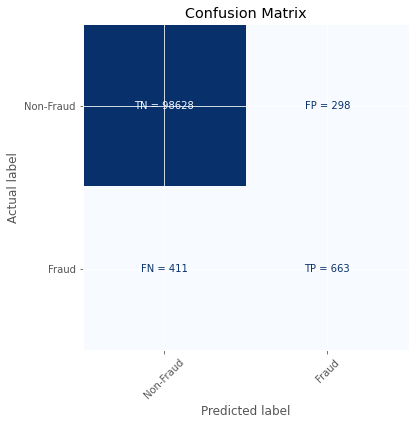

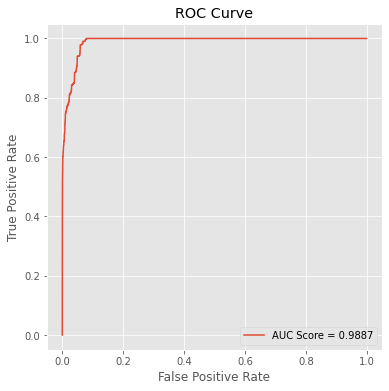

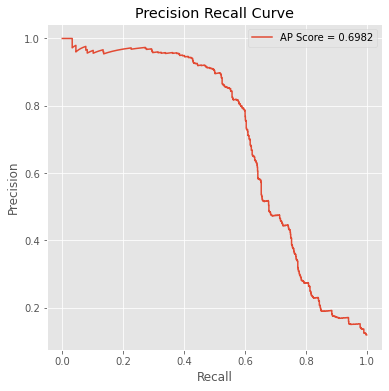

In [15]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=0.2)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=0.2)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

# Conclusion
We trained a Variational Auto-Encoder to find anomalies. This is not its intended use, VAE's are desinged to be generative models. We could now sample from the latent distributions and use the de-coder to create new transactions that should resemble the original transactions.